BERT

In [11]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)



In [4]:
# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [15]:
df = pd.read_excel(r"C:\Users\avtha\Desktop\University\Semester 4\Master thesis\Data\finalized_data.xlsx")
df.shape

(14574, 7)

In [16]:
df.head()

,user_id,ship_id,datetime,score,feedback,feedback_english,cleaned_feedback
0,55284,0,6/7/2022 9:00,1,I paid for it and it doesnâ€™t work.,I paid for it and it doesnâ€™t work.,I paid for it and it doesnt work
1,55318,1,6/7/2022 12:55,1,DÃ¥rlig dekkning!,Bad coverage!,Bad coverage
2,55341,2,6/7/2022 14:56,1,Voucher code doesnâ€™t seem to work,Voucher code doesnâ€™t seem to work,Voucher code doesnt seem to work
3,55342,2,6/7/2022 14:57,1,"No free WiFi available in cabins, unable to bu...","No free WiFi available in cabins, unable to bu...",No free WiFi available in cabins unable to buy...
4,55347,3,6/7/2022 11:51,3,Ja,Yes,Yes


In [17]:
# Let's check for missing values 
df.isnull().sum()

user_id             0
ship_id             0
datetime            0
score               0
feedback            0
feedback_english    1
cleaned_feedback    0
dtype: int64

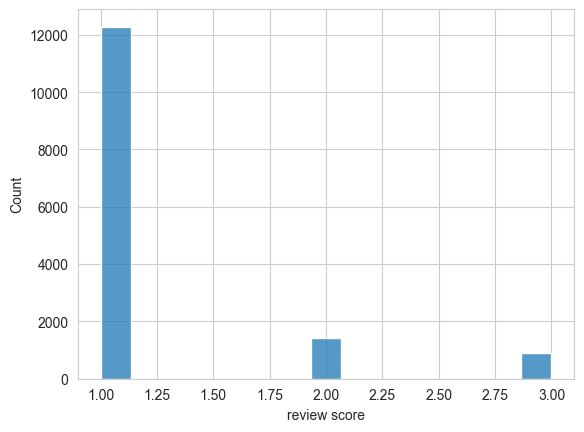

In [18]:
sns.set_style("whitegrid")

# Plot the histogram with grid
sns.histplot(data=df, x="score")
plt.xlabel('review score')
plt.show()

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch

In [20]:
# Load data
data_path = r"C:\Users\avtha\Desktop\University\Semester 4\Master thesis\Data\finalized_data.xlsx"
df = pd.read_excel(data_path)

In [21]:

# Preprocess data
# Assuming 'score' is already in the format you mentioned (1 for bad, 2 for neutral, 3 for good)
# We can convert these scores into sentiment labels: 0 for bad, 1 for neutral, 2 for good
df['sentiment'] = df['score'] - 1

In [22]:

# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

In [23]:
# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [24]:
# Tokenize and vectorize input data
def tokenize_data(data):
    input_ids = []
    attention_masks = []

    for feedback, _ in zip(data['cleaned_feedback'], data['sentiment']):
        encoded_dict = tokenizer.encode_plus(
                            feedback,                      # Text to encode
                            add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
                            max_length = 64,              # Pad & truncate all sentences
                            pad_to_max_length = True,
                            return_attention_mask = True,  # Construct attn. masks
                            return_tensors = 'pt',        # Return PyTorch tensors
                       )
        # Add the encoded sentence to the list
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(data['sentiment'].values)

    return input_ids, attention_masks, labels

train_input_ids, train_attention_masks, train_labels = tokenize_data(train_df)
test_input_ids, test_attention_masks, test_labels = tokenize_data(test_df)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [25]:
# Create TensorDatasets
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Train the model
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

epochs = 3

for epoch in range(epochs):
    model.train()

    for batch in train_dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = batch

        optimizer.zero_grad()

        outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Test the model
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()

correct = 0
total = 0

for batch in test_dataloader:
    batch_input_ids, batch_attention_masks, batch_labels = batch

    with torch.no_grad():
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    
    total += batch_labels.size(0)
    correct += (predictions == batch_labels).sum().item()

accuracy = correct / total
print(f'Accuracy on test set: {accuracy:.2f}')

# Input statement to see its sentiment score
input_statement = "This product exceeded my expectations. Highly recommended!"
input_ids = tokenizer.encode(input_statement, add_special_tokens=True, max_length=64, truncation=True, return_tensors='pt')

with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

print(f'Sentiment score for "{input_statement}": {predicted_class + 1}')  # Adding 1 to match your sentiment scale
